<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_kualitas_rendah1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_time_step = generate_data.window(time_size+1, shift=1, drop_remainder=True)
  flatten_window = add_window_time_step.flat_map(lambda window : window.batch(time_size+1))
  tuple_feature_label = flatten_window.map(lambda window: (window[:-1], window[-1]))
  shuffle_data = tuple_feature_label.shuffle(shuffle_data)
  batch_window = shuffle_data.batch(batch_size).prefetch(1)
  
  return batch_window

def forecast_predict(model, data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f7b5be21550>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_bawah_i.values
date = dataset.index

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=False, shuffle=False)

print(f'{len(x_val)}\n{len(x_train)}')

94
841


In [7]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=700, shuffle_data=100, batch_size=10)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=10, batch_size=1)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=300, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=2, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

### SGD

In [8]:
model= Sequential([
    Conv1D(32, kernel_size=1, padding='causal', activation='relu', strides=2, input_shape=[None, 1]),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    # LSTM(44, return_sequences=True),
    LSTM(109),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          64        
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 109)               75864     
                                                                 
 dense (Dense)               (None, 128)               14080     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [9]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
15/15 [==============================] - 17s 851ms/step - loss: 0.1687 - mae: 0.4104 - mape: 102.6979 - val_loss: 0.0261 - val_mae: 0.1297 - val_mape: 711138.8750
Epoch 2/30
15/15 [==============================] - 9s 537ms/step - loss: 0.1591 - mae: 0.3985 - mape: 99.7004 - val_loss: 0.0232 - val_mae: 0.1230 - val_mape: 3210412.0000
Epoch 3/30
15/15 [==============================] - 6s 388ms/step - loss: 0.1509 - mae: 0.3882 - mape: 97.1168 - val_loss: 0.0208 - val_mae: 0.1167 - val_mape: 5609100.5000
Epoch 4/30
15/15 [==============================] - 6s 388ms/step - loss: 0.1429 - mae: 0.3777 - mape: 94.5072 - val_loss: 0.0186 - val_mae: 0.1106 - val_mape: 7916323.0000
Epoch 5/30
15/15 [==============================] - 6s 391ms/step - loss: 0.1354 - mae: 0.3676 - mape: 91.9601 - val_loss: 0.0168 - val_mae: 0.1047 - val_mape: 10141224.0000
Epoch 6/30
15/15 [==============================] - 7s 452ms/step - loss: 0.1280 - mae: 0.3574 - mape: 89.4196 - val_loss: 0.0152 - v

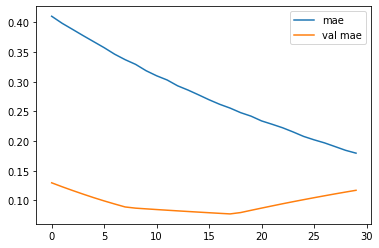

In [10]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1 = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction = forecast_predict(model, test_beras_1, time_size=50, batch_size=1, shuffle_data=100)
result_b = prediction.squeeze()
result_beras = result_b.reshape(-1, 1)
result_beras = scal_range.inverse_transform(result_beras)
result_beras = result_beras.reshape(-1)
data_test_beras = x_test[:-49]
data_test_beras = data_test_beras.reshape(-1)

data_new_beras = pd.DataFrame()
data_new_beras['actual'] = data_test_beras
data_new_beras['prediction'] = result_beras
mae_beras = mean_absolute_error(data_test_beras, result_beras)
mape_beras = mean_absolute_percentage_error(data_test_beras, result_beras)
print(f'mae dari data test beras adalah {mae_beras}\nmape dari data test beras adalah {mape_beras}')
data_new_beras

185/185 [==============================] - 2s 5ms/step
mae dari data test beras adalah 46.8857421875
mape dari data test beras adalah 0.004363442132147074


,actual,prediction
0,10700,10653.692383
1,10700,10653.502930
2,10700,10653.658203
3,10700,10653.583984
4,10700,10653.682617
...,...,...
180,10750,10654.867188
181,10750,10654.839844
182,10750,10654.899414
183,10750,10654.860352


#### type2

In [12]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
741/741 [==============================] - 34s 46ms/step - loss: 0.0101 - mae: 0.0857 - mape: 21.8253 - val_loss: 0.0592 - val_mae: 0.2225 - val_mape: 76005656.0000
Epoch 2/30
741/741 [==============================] - 32s 43ms/step - loss: 0.0025 - mae: 0.0324 - mape: 7.9730 - val_loss: 0.0731 - val_mae: 0.2518 - val_mape: 82303672.0000
Epoch 3/30
741/741 [==============================] - 31s 42ms/step - loss: 0.0022 - mae: 0.0328 - mape: 8.4260 - val_loss: 0.0755 - val_mae: 0.2566 - val_mape: 83322280.0000
Epoch 4/30
741/741 [==============================] - 31s 42ms/step - loss: 0.0022 - mae: 0.0324 - mape: 8.3721 - val_loss: 0.0764 - val_mae: 0.2583 - val_mape: 83682632.0000
Epoch 5/30
741/741 [==============================] - 30s 40ms/step - loss: 0.0023 - mae: 0.0335 - mape: 8.6716 - val_loss: 0.0759 - val_mae: 0.2573 - val_mape: 83478008.0000
Epoch 6/30
741/741 [==============================] - 31s 42ms/step - loss: 0.0022 - mae: 0.0328 - mape: 8.4809 - val_loss: 

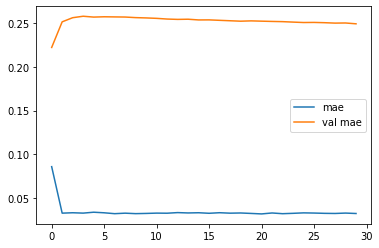

In [13]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

In [14]:
test_beras_t1 = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction_t1 = forecast_predict(model, test_beras_t1, time_size=50, batch_size=1, shuffle_data=100)
result_bt1 = prediction_t1.squeeze()
result_beras_t1 = result_bt1.reshape(-1, 1)
result_beras_t1 = scal_range.inverse_transform(result_beras_t1)
result_beras_t1 = result_beras_t1.reshape(-1)
data_test_beras_t1 = x_test[:-49]
data_test_beras_t1 = data_test_beras_t1.reshape(-1)

data_new_beras_t1 = pd.DataFrame()
data_new_beras_t1['actual'] = data_test_beras_t1
data_new_beras_t1['prediction'] = result_beras_t1
mae_beras_t1 = mean_absolute_error(data_test_beras_t1, result_beras_t1)
mape_beras_t1 = mean_absolute_percentage_error(data_test_beras_t1, result_beras_t1)
print(f'mae dari data test beras adalah {mae_beras_t1}\nmape dari data test beras adalah {mape_beras_t1}')
data_new_beras_t1

185/185 [==============================] - 1s 5ms/step
mae dari data test beras adalah 56.21447951858108
mape dari data test beras adalah 0.005263887317248276


,actual,prediction
0,10700,10725.170898
1,10700,10725.046875
2,10700,10725.233398
3,10700,10725.332031
4,10700,10725.392578
...,...,...
180,10750,10727.511719
181,10750,10727.434570
182,10750,10727.621094
183,10750,10727.453125


### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
109/109 [==============================] - 17s 158ms/step - loss: 0.0019 - mae: 0.0271 - mape: 6.8596 - val_loss: 0.0721 - val_mae: 0.2498 - val_mape: 81877488.0000
Epoch 2/30
109/109 [==============================] - 18s 165ms/step - loss: 0.0020 - mae: 0.0277 - mape: 7.0409 - val_loss: 0.0721 - val_mae: 0.2498 - val_mape: 81889480.0000
Epoch 3/30
109/109 [==============================] - 17s 156ms/step - loss: 0.0019 - mae: 0.0272 - mape: 6.8861 - val_loss: 0.0721 - val_mae: 0.2499 - val_mape: 81912440.0000
Epoch 4/30
109/109 [==============================] - 17s 157ms/step - loss: 0.0019 - mae: 0.0271 - mape: 6.8703 - val_loss: 0.0722 - val_mae: 0.2500 - val_mape: 81928576.0000
Epoch 5/30
109/109 [==============================] - 18s 164ms/step - loss: 0.0019 - mae: 0.0276 - mape: 6.9942 - val_loss: 0.0722 - val_mae: 0.2501 - val_mape: 81947264.0000
Epoch 6/30
109/109 [==============================] - 17s 156ms/step - loss: 0.0019 - mae: 0.0279 - mape: 7.0778 - val_l

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

In [ ]:
test_beras_t2 = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction_t2 = forecast_predict(model, test_beras_t2, time_size=50, batch_size=1, shuffle_data=100)
result_bt2 = prediction_t2.squeeze()
result_beras_t2 = result_bt2.reshape(-1, 1)
result_beras_t2 = scal_range.inverse_transform(result_beras_t2)
result_beras_t2 = result_beras_t2.reshape(-1)
data_test_beras_t2 = x_test[:-49]
data_test_beras_t2 = data_test_beras_t2.reshape(-1)

data_new_beras_t2 = pd.DataFrame()
data_new_beras_t2['actual'] = data_test_beras_t2
data_new_beras_t2['prediction'] = result_beras_t2
mae_beras_t2 = mean_absolute_error(data_test_beras_t2, result_beras_t2)
mape_beras_t2 = mean_absolute_percentage_error(data_test_beras_t2, result_beras_t2)
print(f'mae dari data test beras adalah {mae_beras_t2}\nmape dari data test beras adalah {mape_beras_t2}')
data_new_beras_t2

### Adam

#### Type 1

In [ ]:
model_a= Sequential([
    Conv1D(32, kernel_size=1, padding='causal', activation='relu', strides=2, input_shape=[None, 1]),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    # LSTM(44, return_sequences=True),
    LSTM(109),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model_a.summary()

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch, val_mae_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_a = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction2 = forecast_predict(model_a, test_beras_a, time_size=50, batch_size=1, shuffle_data=100)
result_b2 = prediction2.squeeze()
result_beras2 = result_b2.reshape(-1, 1)
result_beras2 = scal_range.inverse_transform(result_beras2)
result_beras2 = result_beras2.reshape(-1)
data_test_beras2 = x_test[:-49]
data_test_beras2 = data_test_beras2.reshape(-1)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = data_test_beras2
data_new_beras2['prediction'] = result_beras2
mae_beras2 = mean_absolute_error(data_test_beras2, result_beras2)
mape_beras2 = mean_absolute_percentage_error(data_test_beras2, result_beras2)
print(f'mae dari data test beras adalah {mae_beras2}\nmape dari data test beras adalah {mape_beras2}')
data_new_beras2

#### Type 2

#### Type 3

## model 1

### Adam

#### Type 1

In [ ]:
model1= Sequential([
    tf.keras.layers.Conv1D(97, kernel_size=5, 
                                           activation='relu',strides=2,
                                           padding='causal', input_shape=[None, 1]),
                    LSTM(24, return_sequences=True),
                    LSTM(64),
                    Dense(50, activation='relu'),
                    Dense(12, activation='relu'),
                    Dense(1)
])

# model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
#menambah optimizer yang digunakan
model1.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model1.summary()

In [ ]:
history1 = model1.fit(train_step, epochs=30, validation_data=val_step)

In [ ]:
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_2 = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction2 = forecast_predict(model1, test_beras_2, time_size=10, batch_size=5, shuffle_data=1000)
result_b2 = prediction2.squeeze()
result_beras2 = result_b2.reshape(-1, 1)
result_beras2 = scal_range.inverse_transform(result_beras2)
result_beras2 = result_beras2.reshape(-1)
data_test_beras2 = x_test[:-9]
data_test_beras2 = data_test_beras2.reshape(-1)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = data_test_beras2
data_new_beras2['prediction'] = result_beras2
mae_beras2 = mean_absolute_error(data_test_beras2, result_beras2)
mape_beras2 = mean_absolute_percentage_error(data_test_beras2, result_beras2)
print(f'mae dari data test beras adalah {mae_beras2}\nmape dari data test beras adalah {mape_beras2}')
data_new_beras2

#### Type 2

#### Type 3

### SGD

In [ ]:
model1_a= Sequential([
    tf.keras.layers.Conv1D(97, kernel_size=5, 
                                           activation='relu',strides=2,
                                           padding='causal', input_shape=[None, 1]),
                    LSTM(24, return_sequences=True),
                    LSTM(64),
                    Dense(50, activation='relu'),
                    Dense(12, activation='relu'),
                    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

In [ ]:
plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history1_a = model1_a.fit(train_step, epochs=30, validation_data=val_step)

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_1_a = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction1_a = forecast_predict(model1_a, test_beras_1_a, time_size=50, batch_size=1, shuffle_data=100)
result_b1_a = prediction1_a.squeeze()
result_beras1_a = result_b1_a.reshape(-1, 1)
result_beras1_a= scal_range.inverse_transform(result_beras1_a)
result_beras1_a = result_beras1_a.reshape(-1)
data_test_beras1_a = x_test[:-49]
data_test_beras1_a = data_test_beras1_a.reshape(-1)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = data_test_beras1_a
data_new_beras1_a['prediction'] = result_beras1_a
mae_beras1_a = mean_absolute_error(data_test_beras1_a, result_beras1_a)
mape_beras1_a = mean_absolute_percentage_error(data_test_beras1_a, result_beras1_a)
print(f'mae dari data test beras adalah {mae_beras1_a}\nmape dari data test beras adalah {mape_beras1_a}')
data_new_beras1_a

## model 2

### SGD

#### Type 1

In [ ]:
model2= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model2.summary()

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

In [121]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
epoch2 = range(len(mae2))

plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_beras_2 = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction2 = forecast_predict(model2, test_beras_2, time_size=50, batch_size=1, shuffle_data=100)
result_b2 = prediction2.squeeze()
result_beras2 = result_b2.reshape(-1, 1)
result_beras2= scal_range.inverse_transform(result_beras2)
result_beras2 = result_beras2.reshape(-1)
data_test_beras2 = x_test[:-49]
data_test_beras2 = data_test_beras2.reshape(-1)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = data_test_beras2
data_new_beras2['prediction'] = result_beras2
mae_beras2= mean_absolute_error(data_test_beras2, result_beras2)
mape_beras2 = mean_absolute_percentage_error(data_test_beras2, result_beras2)
print(f'mae dari data test beras adalah {mae_beras2}\nmape dari data test beras adalah {mape_beras2}')
data_new_beras2

#### Type2

#### Type 3

### Adam

#### type 1

In [ ]:
model2_1= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
test_beras_2a = scal_range.fit_transform(x_test.reshape(-1, 1))
prediction2a = forecast_predict(model2_a, test_beras_2a, time_size=50, batch_size=1, shuffle_data=100)
result_b2a = prediction2a.squeeze()
result_beras2a = result_b2a.reshape(-1, 1)
result_beras2a= scal_range.inverse_transform(result_beras2a)
result_beras2a = result_beras2a.reshape(-1)
data_test_beras2a = x_test[:-49]
data_test_beras2a = data_test_beras2a.reshape(-1)

data_new_beras2a = pd.DataFrame()
data_new_beras2a['actual'] = data_test_beras2a
data_new_beras2a['prediction'] = result_beras2a
mae_beras2a= mean_absolute_error(data_test_beras2a, result_beras2a)
mape_beras2a = mean_absolute_percentage_error(data_test_beras2a, result_beras2a)
print(f'mae dari data test beras adalah {mae_beras2a}\nmape dari data test beras adalah {mape_beras2a}')
data_new_beras2

#### Type 2

#### Type 3